## 作業說明：
<div>
    <br>
    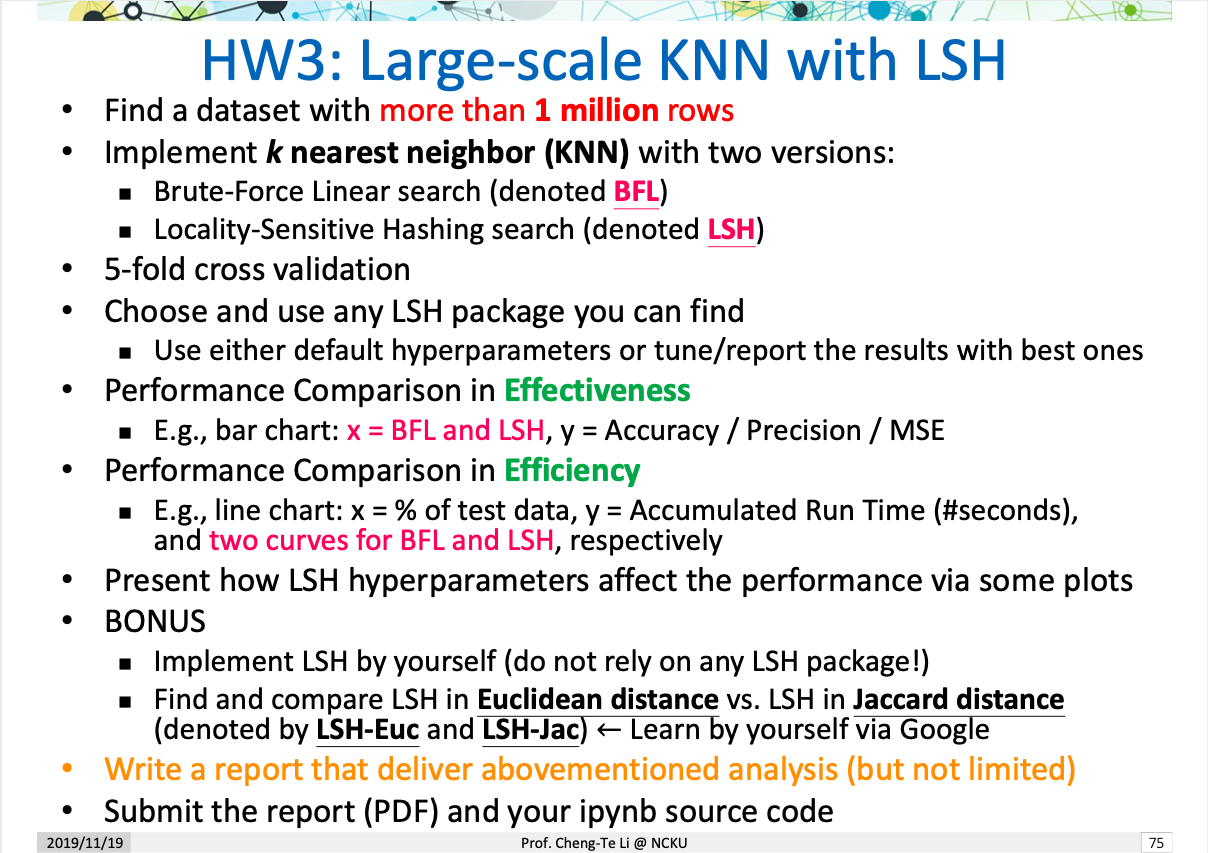
</div>

## 1. Load Datasets

In [ ]:
import pandas as pd
data=pd.read_csv('/Users/leosu/Desktop/BD_HW3/instrument_clean.csv')

In [2]:
# 因為datasketch只能接受set的資料型態，所以用這個function把原本的資料轉換成set
def getSet(i):
    string = str(data.iloc[i]["reviews"])
    string_split = string.split()
    my_set = set(string_split)
    return my_set

## 2. Implement MinHash

### 透過 datasketch 的 MinHash package，就可以在下面這個步驟完成到 step2 (MinHash)
<div>
    <br>
    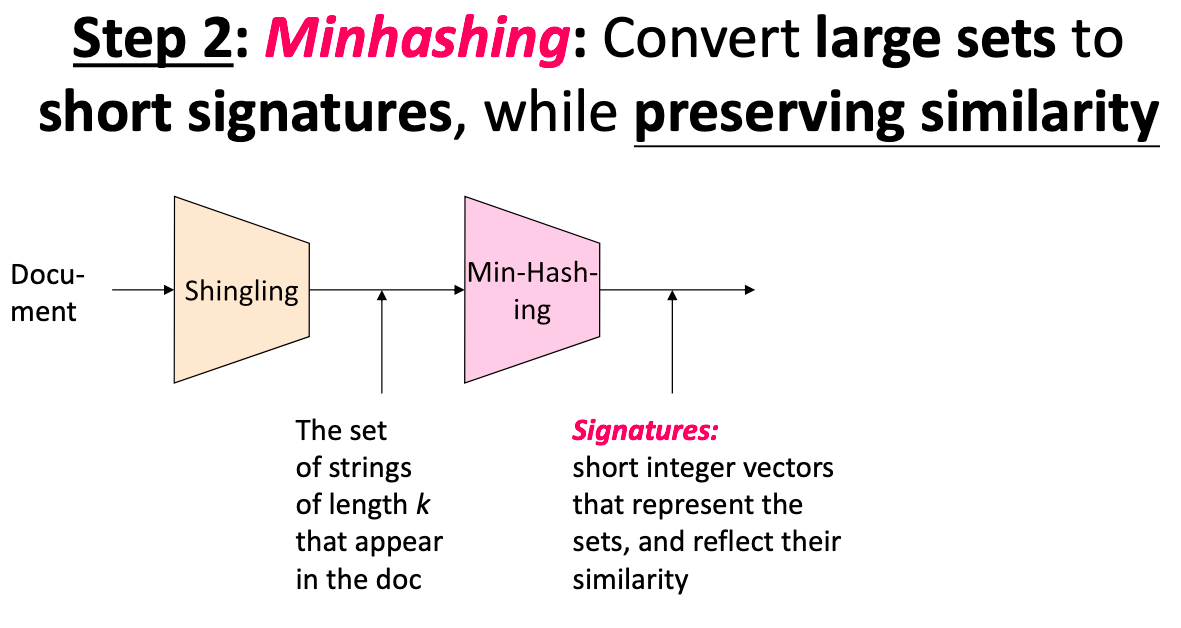
</div>

In [3]:
from datasketch import MinHash, MinHashLSH
import numpy as np
m = list()
for i in range(0,100000):
    m.append(MinHash(num_perm=128))
    for d in getSet(i):
        m[i].update(d.encode('utf8'))

## 3. Implement KNN by Using Brute-Force Linear Search (denoted BFL)

In [136]:
def get_prediction_bf_cv1(k):
    default_rate = 5.0
    jaccard_list = []
    try:
        for i in range(20000,100000):
            jaccard_list.append(m[k].jaccard(m[i]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate

In [155]:
%%time
import time 
tStart = time.time() #計時開始
y_pred = []
BFL_time=[]
for i in range(0,20000):
    print("test" + str(i))
    y_pred.append(get_prediction_bf_cv1(i))
    tEnd = time.time()
    BFL_time.append(tEnd-tStart)

test0
test1
test2
test3
test4
test5
test6
test7
test8
test9
test10
test11
test12
test13
test14
test15
test16
test17
test18
test19
test20
test21
test22
test23
test24
test25
test26
test27
test28
test29
test30
test31
test32
test33
test34
test35
test36
test37
test38
test39
test40
test41
test42
test43
test44
test45
test46
test47
test48
test49
test50
test51
test52
test53
test54
test55
test56
test57
test58
test59
test60
test61
test62
test63
test64
test65
test66
test67
test68
test69
test70
test71
test72
test73
test74
test75
test76
test77
test78
test79
test80
test81
test82
test83
test84
test85
test86
test87
test88
test89
test90
test91
test92
test93
test94
test95
test96
test97
test98
test99
test100
test101
test102
test103
test104
test105
test106
test107
test108
test109
test110
test111
test112
test113
test114
test115
test116
test117
test118
test119
test120
test121
test122
test123
test124
test125
test126
test127
test128
test129
test130
test131
test132
test133
test134
test135
test136
test137
test13

test1034
test1035
test1036
test1037
test1038
test1039
test1040
test1041
test1042
test1043
test1044
test1045
test1046
test1047
test1048
test1049
test1050
test1051
test1052
test1053
test1054
test1055
test1056
test1057
test1058
test1059
test1060
test1061
test1062
test1063
test1064
test1065
test1066
test1067
test1068
test1069
test1070
test1071
test1072
test1073
test1074
test1075
test1076
test1077
test1078
test1079
test1080
test1081
test1082
test1083
test1084
test1085
test1086
test1087
test1088
test1089
test1090
test1091
test1092
test1093
test1094
test1095
test1096
test1097
test1098
test1099
test1100
test1101
test1102
test1103
test1104
test1105
test1106
test1107
test1108
test1109
test1110
test1111
test1112
test1113
test1114
test1115
test1116
test1117
test1118
test1119
test1120
test1121
test1122
test1123
test1124
test1125
test1126
test1127
test1128
test1129
test1130
test1131
test1132
test1133
test1134
test1135
test1136
test1137
test1138
test1139
test1140
test1141
test1142
test1143
test1144
t

test1945
test1946
test1947
test1948
test1949
test1950
test1951
test1952
test1953
test1954
test1955
test1956
test1957
test1958
test1959
test1960
test1961
test1962
test1963
test1964
test1965
test1966
test1967
test1968
test1969
test1970
test1971
test1972
test1973
test1974
test1975
test1976
test1977
test1978
test1979
test1980
test1981
test1982
test1983
test1984
test1985
test1986
test1987
test1988
test1989
test1990
test1991
test1992
test1993
test1994
test1995
test1996
test1997
test1998
test1999
test2000
test2001
test2002
test2003
test2004
test2005
test2006
test2007
test2008
test2009
test2010
test2011
test2012
test2013
test2014
test2015
test2016
test2017
test2018
test2019
test2020
test2021
test2022
test2023
test2024
test2025
test2026
test2027
test2028
test2029
test2030
test2031
test2032
test2033
test2034
test2035
test2036
test2037
test2038
test2039
test2040
test2041
test2042
test2043
test2044
test2045
test2046
test2047
test2048
test2049
test2050
test2051
test2052
test2053
test2054
test2055
t

test2856
test2857
test2858
test2859
test2860
test2861
test2862
test2863
test2864
test2865
test2866
test2867
test2868
test2869
test2870
test2871
test2872
test2873
test2874
test2875
test2876
test2877
test2878
test2879
test2880
test2881
test2882
test2883
test2884
test2885
test2886
test2887
test2888
test2889
test2890
test2891
test2892
test2893
test2894
test2895
test2896
test2897
test2898
test2899
test2900
test2901
test2902
test2903
test2904
test2905
test2906
test2907
test2908
test2909
test2910
test2911
test2912
test2913
test2914
test2915
test2916
test2917
test2918
test2919
test2920
test2921
test2922
test2923
test2924
test2925
test2926
test2927
test2928
test2929
test2930
test2931
test2932
test2933
test2934
test2935
test2936
test2937
test2938
test2939
test2940
test2941
test2942
test2943
test2944
test2945
test2946
test2947
test2948
test2949
test2950
test2951
test2952
test2953
test2954
test2955
test2956
test2957
test2958
test2959
test2960
test2961
test2962
test2963
test2964
test2965
test2966
t

test3767
test3768
test3769
test3770
test3771
test3772
test3773
test3774
test3775
test3776
test3777
test3778
test3779
test3780
test3781
test3782
test3783
test3784
test3785
test3786
test3787
test3788
test3789
test3790
test3791
test3792
test3793
test3794
test3795
test3796
test3797
test3798
test3799
test3800
test3801
test3802
test3803
test3804
test3805
test3806
test3807
test3808
test3809
test3810
test3811
test3812
test3813
test3814
test3815
test3816
test3817
test3818
test3819
test3820
test3821
test3822
test3823
test3824
test3825
test3826
test3827
test3828
test3829
test3830
test3831
test3832
test3833
test3834
test3835
test3836
test3837
test3838
test3839
test3840
test3841
test3842
test3843
test3844
test3845
test3846
test3847
test3848
test3849
test3850
test3851
test3852
test3853
test3854
test3855
test3856
test3857
test3858
test3859
test3860
test3861
test3862
test3863
test3864
test3865
test3866
test3867
test3868
test3869
test3870
test3871
test3872
test3873
test3874
test3875
test3876
test3877
t

test4678
test4679
test4680
test4681
test4682
test4683
test4684
test4685
test4686
test4687
test4688
test4689
test4690
test4691
test4692
test4693
test4694
test4695
test4696
test4697
test4698
test4699
test4700
test4701
test4702
test4703
test4704
test4705
test4706
test4707
test4708
test4709
test4710
test4711
test4712
test4713
test4714
test4715
test4716
test4717
test4718
test4719
test4720
test4721
test4722
test4723
test4724
test4725
test4726
test4727
test4728
test4729
test4730
test4731
test4732
test4733
test4734
test4735
test4736
test4737
test4738
test4739
test4740
test4741
test4742
test4743
test4744
test4745
test4746
test4747
test4748
test4749
test4750
test4751
test4752
test4753
test4754
test4755
test4756
test4757
test4758
test4759
test4760
test4761
test4762
test4763
test4764
test4765
test4766
test4767
test4768
test4769
test4770
test4771
test4772
test4773
test4774
test4775
test4776
test4777
test4778
test4779
test4780
test4781
test4782
test4783
test4784
test4785
test4786
test4787
test4788
t

test5589
test5590
test5591
test5592
test5593
test5594
test5595
test5596
test5597
test5598
test5599
test5600
test5601
test5602
test5603
test5604
test5605
test5606
test5607
test5608
test5609
test5610
test5611
test5612
test5613
test5614
test5615
test5616
test5617
test5618
test5619
test5620
test5621
test5622
test5623
test5624
test5625
test5626
test5627
test5628
test5629
test5630
test5631
test5632
test5633
test5634
test5635
test5636
test5637
test5638
test5639
test5640
test5641
test5642
test5643
test5644
test5645
test5646
test5647
test5648
test5649
test5650
test5651
test5652
test5653
test5654
test5655
test5656
test5657
test5658
test5659
test5660
test5661
test5662
test5663
test5664
test5665
test5666
test5667
test5668
test5669
test5670
test5671
test5672
test5673
test5674
test5675
test5676
test5677
test5678
test5679
test5680
test5681
test5682
test5683
test5684
test5685
test5686
test5687
test5688
test5689
test5690
test5691
test5692
test5693
test5694
test5695
test5696
test5697
test5698
test5699
t

test6500
test6501
test6502
test6503
test6504
test6505
test6506
test6507
test6508
test6509
test6510
test6511
test6512
test6513
test6514
test6515
test6516
test6517
test6518
test6519
test6520
test6521
test6522
test6523
test6524
test6525
test6526
test6527
test6528
test6529
test6530
test6531
test6532
test6533
test6534
test6535
test6536
test6537
test6538
test6539
test6540
test6541
test6542
test6543
test6544
test6545
test6546
test6547
test6548
test6549
test6550
test6551
test6552
test6553
test6554
test6555
test6556
test6557
test6558
test6559
test6560
test6561
test6562
test6563
test6564
test6565
test6566
test6567
test6568
test6569
test6570
test6571
test6572
test6573
test6574
test6575
test6576
test6577
test6578
test6579
test6580
test6581
test6582
test6583
test6584
test6585
test6586
test6587
test6588
test6589
test6590
test6591
test6592
test6593
test6594
test6595
test6596
test6597
test6598
test6599
test6600
test6601
test6602
test6603
test6604
test6605
test6606
test6607
test6608
test6609
test6610
t

test7411
test7412
test7413
test7414
test7415
test7416
test7417
test7418
test7419
test7420
test7421
test7422
test7423
test7424
test7425
test7426
test7427
test7428
test7429
test7430
test7431
test7432
test7433
test7434
test7435
test7436
test7437
test7438
test7439
test7440
test7441
test7442
test7443
test7444
test7445
test7446
test7447
test7448
test7449
test7450
test7451
test7452
test7453
test7454
test7455
test7456
test7457
test7458
test7459
test7460
test7461
test7462
test7463
test7464
test7465
test7466
test7467
test7468
test7469
test7470
test7471
test7472
test7473
test7474
test7475
test7476
test7477
test7478
test7479
test7480
test7481
test7482
test7483
test7484
test7485
test7486
test7487
test7488
test7489
test7490
test7491
test7492
test7493
test7494
test7495
test7496
test7497
test7498
test7499
test7500
test7501
test7502
test7503
test7504
test7505
test7506
test7507
test7508
test7509
test7510
test7511
test7512
test7513
test7514
test7515
test7516
test7517
test7518
test7519
test7520
test7521
t

test8322
test8323
test8324
test8325
test8326
test8327
test8328
test8329
test8330
test8331
test8332
test8333
test8334
test8335
test8336
test8337
test8338
test8339
test8340
test8341
test8342
test8343
test8344
test8345
test8346
test8347
test8348
test8349
test8350
test8351
test8352
test8353
test8354
test8355
test8356
test8357
test8358
test8359
test8360
test8361
test8362
test8363
test8364
test8365
test8366
test8367
test8368
test8369
test8370
test8371
test8372
test8373
test8374
test8375
test8376
test8377
test8378
test8379
test8380
test8381
test8382
test8383
test8384
test8385
test8386
test8387
test8388
test8389
test8390
test8391
test8392
test8393
test8394
test8395
test8396
test8397
test8398
test8399
test8400
test8401
test8402
test8403
test8404
test8405
test8406
test8407
test8408
test8409
test8410
test8411
test8412
test8413
test8414
test8415
test8416
test8417
test8418
test8419
test8420
test8421
test8422
test8423
test8424
test8425
test8426
test8427
test8428
test8429
test8430
test8431
test8432
t

test9233
test9234
test9235
test9236
test9237
test9238
test9239
test9240
test9241
test9242
test9243
test9244
test9245
test9246
test9247
test9248
test9249
test9250
test9251
test9252
test9253
test9254
test9255
test9256
test9257
test9258
test9259
test9260
test9261
test9262
test9263
test9264
test9265
test9266
test9267
test9268
test9269
test9270
test9271
test9272
test9273
test9274
test9275
test9276
test9277
test9278
test9279
test9280
test9281
test9282
test9283
test9284
test9285
test9286
test9287
test9288
test9289
test9290
test9291
test9292
test9293
test9294
test9295
test9296
test9297
test9298
test9299
test9300
test9301
test9302
test9303
test9304
test9305
test9306
test9307
test9308
test9309
test9310
test9311
test9312
test9313
test9314
test9315
test9316
test9317
test9318
test9319
test9320
test9321
test9322
test9323
test9324
test9325
test9326
test9327
test9328
test9329
test9330
test9331
test9332
test9333
test9334
test9335
test9336
test9337
test9338
test9339
test9340
test9341
test9342
test9343
t

test10129
test10130
test10131
test10132
test10133
test10134
test10135
test10136
test10137
test10138
test10139
test10140
test10141
test10142
test10143
test10144
test10145
test10146
test10147
test10148
test10149
test10150
test10151
test10152
test10153
test10154
test10155
test10156
test10157
test10158
test10159
test10160
test10161
test10162
test10163
test10164
test10165
test10166
test10167
test10168
test10169
test10170
test10171
test10172
test10173
test10174
test10175
test10176
test10177
test10178
test10179
test10180
test10181
test10182
test10183
test10184
test10185
test10186
test10187
test10188
test10189
test10190
test10191
test10192
test10193
test10194
test10195
test10196
test10197
test10198
test10199
test10200
test10201
test10202
test10203
test10204
test10205
test10206
test10207
test10208
test10209
test10210
test10211
test10212
test10213
test10214
test10215
test10216
test10217
test10218
test10219
test10220
test10221
test10222
test10223
test10224
test10225
test10226
test10227
test10228


test10949
test10950
test10951
test10952
test10953
test10954
test10955
test10956
test10957
test10958
test10959
test10960
test10961
test10962
test10963
test10964
test10965
test10966
test10967
test10968
test10969
test10970
test10971
test10972
test10973
test10974
test10975
test10976
test10977
test10978
test10979
test10980
test10981
test10982
test10983
test10984
test10985
test10986
test10987
test10988
test10989
test10990
test10991
test10992
test10993
test10994
test10995
test10996
test10997
test10998
test10999
test11000
test11001
test11002
test11003
test11004
test11005
test11006
test11007
test11008
test11009
test11010
test11011
test11012
test11013
test11014
test11015
test11016
test11017
test11018
test11019
test11020
test11021
test11022
test11023
test11024
test11025
test11026
test11027
test11028
test11029
test11030
test11031
test11032
test11033
test11034
test11035
test11036
test11037
test11038
test11039
test11040
test11041
test11042
test11043
test11044
test11045
test11046
test11047
test11048


test11769
test11770
test11771
test11772
test11773
test11774
test11775
test11776
test11777
test11778
test11779
test11780
test11781
test11782
test11783
test11784
test11785
test11786
test11787
test11788
test11789
test11790
test11791
test11792
test11793
test11794
test11795
test11796
test11797
test11798
test11799
test11800
test11801
test11802
test11803
test11804
test11805
test11806
test11807
test11808
test11809
test11810
test11811
test11812
test11813
test11814
test11815
test11816
test11817
test11818
test11819
test11820
test11821
test11822
test11823
test11824
test11825
test11826
test11827
test11828
test11829
test11830
test11831
test11832
test11833
test11834
test11835
test11836
test11837
test11838
test11839
test11840
test11841
test11842
test11843
test11844
test11845
test11846
test11847
test11848
test11849
test11850
test11851
test11852
test11853
test11854
test11855
test11856
test11857
test11858
test11859
test11860
test11861
test11862
test11863
test11864
test11865
test11866
test11867
test11868


test12589
test12590
test12591
test12592
test12593
test12594
test12595
test12596
test12597
test12598
test12599
test12600
test12601
test12602
test12603
test12604
test12605
test12606
test12607
test12608
test12609
test12610
test12611
test12612
test12613
test12614
test12615
test12616
test12617
test12618
test12619
test12620
test12621
test12622
test12623
test12624
test12625
test12626
test12627
test12628
test12629
test12630
test12631
test12632
test12633
test12634
test12635
test12636
test12637
test12638
test12639
test12640
test12641
test12642
test12643
test12644
test12645
test12646
test12647
test12648
test12649
test12650
test12651
test12652
test12653
test12654
test12655
test12656
test12657
test12658
test12659
test12660
test12661
test12662
test12663
test12664
test12665
test12666
test12667
test12668
test12669
test12670
test12671
test12672
test12673
test12674
test12675
test12676
test12677
test12678
test12679
test12680
test12681
test12682
test12683
test12684
test12685
test12686
test12687
test12688


test13409
test13410
test13411
test13412
test13413
test13414
test13415
test13416
test13417
test13418
test13419
test13420
test13421
test13422
test13423
test13424
test13425
test13426
test13427
test13428
test13429
test13430
test13431
test13432
test13433
test13434
test13435
test13436
test13437
test13438
test13439
test13440
test13441
test13442
test13443
test13444
test13445
test13446
test13447
test13448
test13449
test13450
test13451
test13452
test13453
test13454
test13455
test13456
test13457
test13458
test13459
test13460
test13461
test13462
test13463
test13464
test13465
test13466
test13467
test13468
test13469
test13470
test13471
test13472
test13473
test13474
test13475
test13476
test13477
test13478
test13479
test13480
test13481
test13482
test13483
test13484
test13485
test13486
test13487
test13488
test13489
test13490
test13491
test13492
test13493
test13494
test13495
test13496
test13497
test13498
test13499
test13500
test13501
test13502
test13503
test13504
test13505
test13506
test13507
test13508


test14229
test14230
test14231
test14232
test14233
test14234
test14235
test14236
test14237
test14238
test14239
test14240
test14241
test14242
test14243
test14244
test14245
test14246
test14247
test14248
test14249
test14250
test14251
test14252
test14253
test14254
test14255
test14256
test14257
test14258
test14259
test14260
test14261
test14262
test14263
test14264
test14265
test14266
test14267
test14268
test14269
test14270
test14271
test14272
test14273
test14274
test14275
test14276
test14277
test14278
test14279
test14280
test14281
test14282
test14283
test14284
test14285
test14286
test14287
test14288
test14289
test14290
test14291
test14292
test14293
test14294
test14295
test14296
test14297
test14298
test14299
test14300
test14301
test14302
test14303
test14304
test14305
test14306
test14307
test14308
test14309
test14310
test14311
test14312
test14313
test14314
test14315
test14316
test14317
test14318
test14319
test14320
test14321
test14322
test14323
test14324
test14325
test14326
test14327
test14328


test15049
test15050
test15051
test15052
test15053
test15054
test15055
test15056
test15057
test15058
test15059
test15060
test15061
test15062
test15063
test15064
test15065
test15066
test15067
test15068
test15069
test15070
test15071
test15072
test15073
test15074
test15075
test15076
test15077
test15078
test15079
test15080
test15081
test15082
test15083
test15084
test15085
test15086
test15087
test15088
test15089
test15090
test15091
test15092
test15093
test15094
test15095
test15096
test15097
test15098
test15099
test15100
test15101
test15102
test15103
test15104
test15105
test15106
test15107
test15108
test15109
test15110
test15111
test15112
test15113
test15114
test15115
test15116
test15117
test15118
test15119
test15120
test15121
test15122
test15123
test15124
test15125
test15126
test15127
test15128
test15129
test15130
test15131
test15132
test15133
test15134
test15135
test15136
test15137
test15138
test15139
test15140
test15141
test15142
test15143
test15144
test15145
test15146
test15147
test15148


test15869
test15870
test15871
test15872
test15873
test15874
test15875
test15876
test15877
test15878
test15879
test15880
test15881
test15882
test15883
test15884
test15885
test15886
test15887
test15888
test15889
test15890
test15891
test15892
test15893
test15894
test15895
test15896
test15897
test15898
test15899
test15900
test15901
test15902
test15903
test15904
test15905
test15906
test15907
test15908
test15909
test15910
test15911
test15912
test15913
test15914
test15915
test15916
test15917
test15918
test15919
test15920
test15921
test15922
test15923
test15924
test15925
test15926
test15927
test15928
test15929
test15930
test15931
test15932
test15933
test15934
test15935
test15936
test15937
test15938
test15939
test15940
test15941
test15942
test15943
test15944
test15945
test15946
test15947
test15948
test15949
test15950
test15951
test15952
test15953
test15954
test15955
test15956
test15957
test15958
test15959
test15960
test15961
test15962
test15963
test15964
test15965
test15966
test15967
test15968


test16689
test16690
test16691
test16692
test16693
test16694
test16695
test16696
test16697
test16698
test16699
test16700
test16701
test16702
test16703
test16704
test16705
test16706
test16707
test16708
test16709
test16710
test16711
test16712
test16713
test16714
test16715
test16716
test16717
test16718
test16719
test16720
test16721
test16722
test16723
test16724
test16725
test16726
test16727
test16728
test16729
test16730
test16731
test16732
test16733
test16734
test16735
test16736
test16737
test16738
test16739
test16740
test16741
test16742
test16743
test16744
test16745
test16746
test16747
test16748
test16749
test16750
test16751
test16752
test16753
test16754
test16755
test16756
test16757
test16758
test16759
test16760
test16761
test16762
test16763
test16764
test16765
test16766
test16767
test16768
test16769
test16770
test16771
test16772
test16773
test16774
test16775
test16776
test16777
test16778
test16779
test16780
test16781
test16782
test16783
test16784
test16785
test16786
test16787
test16788


test17509
test17510
test17511
test17512
test17513
test17514
test17515
test17516
test17517
test17518
test17519
test17520
test17521
test17522
test17523
test17524
test17525
test17526
test17527
test17528
test17529
test17530
test17531
test17532
test17533
test17534
test17535
test17536
test17537
test17538
test17539
test17540
test17541
test17542
test17543
test17544
test17545
test17546
test17547
test17548
test17549
test17550
test17551
test17552
test17553
test17554
test17555
test17556
test17557
test17558
test17559
test17560
test17561
test17562
test17563
test17564
test17565
test17566
test17567
test17568
test17569
test17570
test17571
test17572
test17573
test17574
test17575
test17576
test17577
test17578
test17579
test17580
test17581
test17582
test17583
test17584
test17585
test17586
test17587
test17588
test17589
test17590
test17591
test17592
test17593
test17594
test17595
test17596
test17597
test17598
test17599
test17600
test17601
test17602
test17603
test17604
test17605
test17606
test17607
test17608


test18329
test18330
test18331
test18332
test18333
test18334
test18335
test18336
test18337
test18338
test18339
test18340
test18341
test18342
test18343
test18344
test18345
test18346
test18347
test18348
test18349
test18350
test18351
test18352
test18353
test18354
test18355
test18356
test18357
test18358
test18359
test18360
test18361
test18362
test18363
test18364
test18365
test18366
test18367
test18368
test18369
test18370
test18371
test18372
test18373
test18374
test18375
test18376
test18377
test18378
test18379
test18380
test18381
test18382
test18383
test18384
test18385
test18386
test18387
test18388
test18389
test18390
test18391
test18392
test18393
test18394
test18395
test18396
test18397
test18398
test18399
test18400
test18401
test18402
test18403
test18404
test18405
test18406
test18407
test18408
test18409
test18410
test18411
test18412
test18413
test18414
test18415
test18416
test18417
test18418
test18419
test18420
test18421
test18422
test18423
test18424
test18425
test18426
test18427
test18428


test19149
test19150
test19151
test19152
test19153
test19154
test19155
test19156
test19157
test19158
test19159
test19160
test19161
test19162
test19163
test19164
test19165
test19166
test19167
test19168
test19169
test19170
test19171
test19172
test19173
test19174
test19175
test19176
test19177
test19178
test19179
test19180
test19181
test19182
test19183
test19184
test19185
test19186
test19187
test19188
test19189
test19190
test19191
test19192
test19193
test19194
test19195
test19196
test19197
test19198
test19199
test19200
test19201
test19202
test19203
test19204
test19205
test19206
test19207
test19208
test19209
test19210
test19211
test19212
test19213
test19214
test19215
test19216
test19217
test19218
test19219
test19220
test19221
test19222
test19223
test19224
test19225
test19226
test19227
test19228
test19229
test19230
test19231
test19232
test19233
test19234
test19235
test19236
test19237
test19238
test19239
test19240
test19241
test19242
test19243
test19244
test19245
test19246
test19247
test19248


test19969
test19970
test19971
test19972
test19973
test19974
test19975
test19976
test19977
test19978
test19979
test19980
test19981
test19982
test19983
test19984
test19985
test19986
test19987
test19988
test19989
test19990
test19991
test19992
test19993
test19994
test19995
test19996
test19997
test19998
test19999
CPU times: user 1h 50min 46s, sys: 1min 27s, total: 1h 52min 14s
Wall time: 1h 59min 25s


In [156]:
y_pred_df = pd.DataFrame(y_pred, columns=["rate"])

In [157]:
y_true = data.iloc[0:20000]["rate"]

In [158]:
from sklearn.metrics import accuracy_score
score_bf = accuracy_score(y_true, y_pred_df, normalize=True)

In [159]:
score_bf

0.48265

## 4. Implement KNN by Using Locality-Sensitive Hashing Search (denoted LSH)

### 透過 datasketch 的 MinHashLSH package，就可以在下面這個步驟完成LSH
<div>
    <br>
    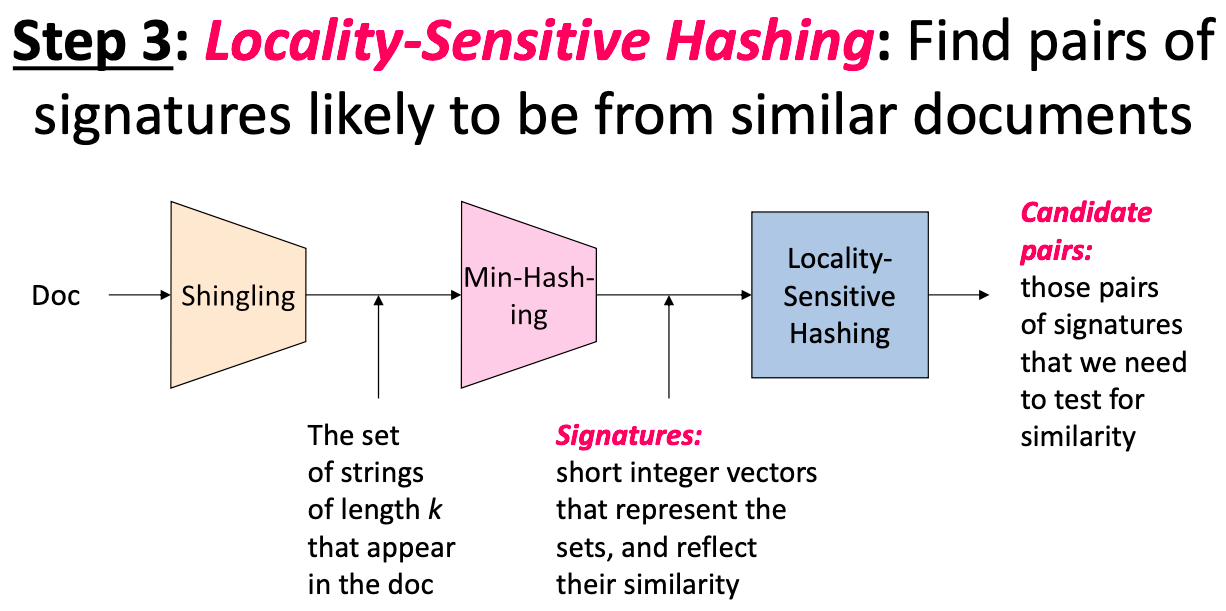
</div>

In [127]:
# Create LSH index
lsh = MinHashLSH(threshold=0.2, num_perm=128)
for i in range(20000,100000):
    lsh.insert(i, m[i])

In [128]:
# number of bands
lsh.h

128

In [129]:
def get_prediction(k):
    default_rate = 5.0
    result = lsh.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate
    
#     print(max_m)
#     print(data.iloc[max_m]["rate"])

In [130]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh = []
LSH_time=[]
for i in range(0,20000):
    y_pred_lsh.append(get_prediction(i))
    tEnd = time.time()
    LSH_time.append(tEnd-tStart)

337 value_error
492 value_error
504 value_error
1362 value_error
2076 value_error
2116 value_error
2342 value_error
2891 value_error
3261 value_error
3577 value_error
3729 value_error
3929 value_error
4400 value_error
4423 value_error
4498 value_error
4520 value_error
4542 value_error
4802 value_error
5015 value_error
5019 value_error
5113 value_error
5851 value_error
5907 value_error
5909 value_error
5913 value_error
5964 value_error
6315 value_error
6764 value_error
6873 value_error
6927 value_error
7011 value_error
7122 value_error
7223 value_error
7477 value_error
7487 value_error
7625 value_error
7638 value_error
7869 value_error
8116 value_error
8228 value_error
8241 value_error
8290 value_error
8492 value_error
8540 value_error
8728 value_error
10955 value_error
11189 value_error
11261 value_error
11342 value_error
11630 value_error
11774 value_error
11964 value_error
11982 value_error
12544 value_error
12633 value_error
12882 value_error
13401 value_error
13427 value_error
1344

In [131]:
y_pred_df_lsh = pd.DataFrame(y_pred_lsh, columns=["rate"])
y_true_lsh = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh = accuracy_score(y_true_lsh, y_pred_df_lsh, normalize=True)
score_lsh

0.4059

## 5. Performance Comparison in Effectiveness and Efficiency

### Effectiveness

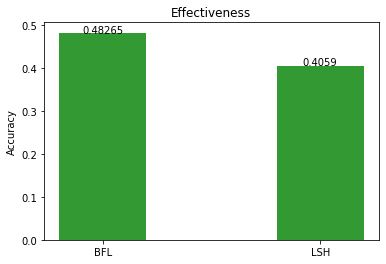

In [45]:
import matplotlib.pyplot as plt

effectiveness = [score_bf,score_lsh]

plt.bar(range(2), effectiveness, 0.4,color='g', alpha = 0.8,align='center')

plt.ylabel('Accuracy')
plt.title('Effectiveness')

plt.xticks(range(2),['BFL','LSH'])

for x,y in enumerate(effectiveness):
    plt.text(x,y,'%s' %y,ha='center')

plt.show()

### Efficency

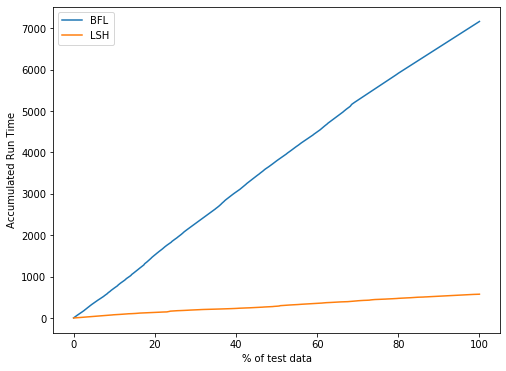

In [160]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(0,figsize=(8,6))

x = [x/len(BFL_time)*100 for x in range(len(BFL_time))]

line_BFL, = plt.plot(x, BFL_time, label='BFL')
line_LSH, = plt.plot(x, LSH_time, label='LSH')
plt.xlabel('% of test data')
plt.ylabel('Accumulated Run Time')
# plt.ylim([0,2])
plt.legend(handles=[line_BFL,line_LSH], loc=0)

plt.show()
plt.close()

在Effectiveness的表現上，很明顯的BFL的準確度較高，但BFL所要花的時間卻是LSH的好幾倍之多。

因為BFL是用最naive的方式一個一個比較，所以準確度通常來說會比較高，但是它卻要花上非常大量的時間成本，在資料量越來越大的現在，LSH勢必會是比較理想的作法，因為LSH大幅的降低了運算的時間，又可以達到還不錯的準確度。

## 6. Change LSH Hyperparameters

### 6.1. Change num_perm (number of permutation)

In [58]:
from datasketch import MinHash, MinHashLSH
import numpy as np
m_256_n = list()
for i in range(0,100000):
    m_256_n.append(MinHash(num_perm=256))
    for d in getSet(i):
        m_256_n[i].update(d.encode('utf8'))

In [59]:
# Create LSH index
#100 bands
lsh_256_n = MinHashLSH(threshold=0.2, num_perm=256)
#先把 0-19999 當test
for i in range(20000,100000):
    lsh_256_n.insert(i, m_256_n[i])


In [60]:
def get_prediction_256_n(k):
    default_rate = 5.0
    result = lsh_256_n.query(m_256_n[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m_256_n[k].jaccard(m_256_n[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate
    
#     print(max_m)
#     print(data.iloc[max_m]["rate"])

In [61]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_256_n = []
LSH_time_256_n=[]
for i in range(0,20000):
    y_pred_lsh_256_n.append(get_prediction_256_n(i))
    tEnd = time.time()
    LSH_time_256_n.append(tEnd-tStart)

337 value_error
492 value_error
504 value_error
588 value_error
1242 value_error
1252 value_error
1362 value_error
1389 value_error
1620 value_error
2116 value_error
2118 value_error
2891 value_error
2941 value_error
3261 value_error
3577 value_error
3729 value_error
3929 value_error
3970 value_error
4108 value_error
4400 value_error
4423 value_error
4498 value_error
4520 value_error
4542 value_error
4802 value_error
5015 value_error
5019 value_error
5113 value_error
5851 value_error
5907 value_error
5913 value_error
5957 value_error
5964 value_error
6315 value_error
6508 value_error
6641 value_error
6764 value_error
6873 value_error
6927 value_error
7011 value_error
7122 value_error
7223 value_error
7224 value_error
7477 value_error
7487 value_error
7625 value_error
7869 value_error
7873 value_error
8058 value_error
8116 value_error
8178 value_error
8228 value_error
8241 value_error
8290 value_error
8383 value_error
8492 value_error
8540 value_error
8685 value_error
8728 value_error
9

In [67]:
y_pred_df_lsh_256_n = pd.DataFrame(y_pred_lsh_256_n, columns=["rate"])
y_true_lsh_256_n = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_256_n = accuracy_score(y_true_lsh_256_n, y_pred_df_lsh_256_n, normalize=True)
score_lsh_256_n

0.41515

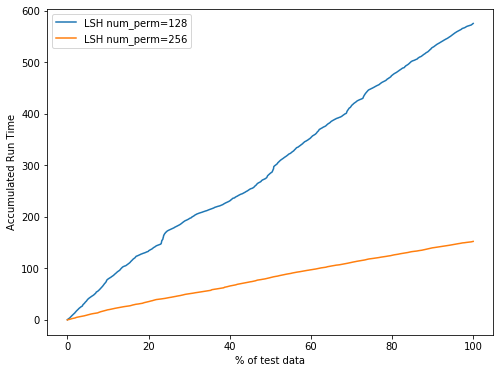

In [132]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(0,figsize=(8,6))

x = [x/len(LSH_time)*100 for x in range(len(LSH_time))]

# line_BFL, = plt.plot(x, BFL_time, label='BFL')
line_LSH, = plt.plot(x, LSH_time, label='LSH num_perm=128')
line_LSH_256_n, = plt.plot(x, LSH_time_256_n, label='LSH num_perm=256')

plt.xlabel('% of test data')
plt.ylabel('Accumulated Run Time')
# plt.ylim([0,2])
plt.legend(handles=[line_LSH,line_LSH_256_n], loc=0)

plt.show()
plt.close()

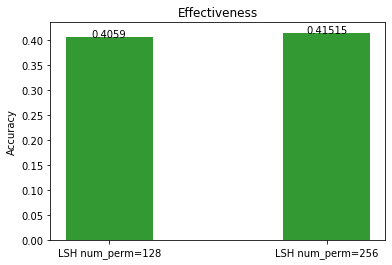

In [133]:
import matplotlib.pyplot as plt

effectiveness = [score_lsh,score_lsh_256_n]

plt.bar(range(2), effectiveness, 0.4,color='g', alpha = 0.8,align='center')

plt.ylabel('Accuracy')
plt.title('Effectiveness')

plt.xticks(range(2),['LSH num_perm=128','LSH num_perm=256'])

for x,y in enumerate(effectiveness):
    plt.text(x,y,'%s' %y,ha='center')

plt.show()

### 6.2. Change # of bands

#### 16 bands

In [147]:
# Create LSH index
#16 bands
lsh_16b = MinHashLSH(threshold=0.2, num_perm=128, params=(16,8))
for i in range(20000,100000):
    lsh_16b.insert(i, m[i])


In [148]:
# number of bands
lsh_16b.b

16

In [149]:
def get_prediction_16b(k):
    default_rate = 5.0
    result = lsh_16b.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
#         print(k, "value_error")
        return default_rate

In [150]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_16b = []
LSH_time_16b = []
for i in range(0,20000):
    y_pred_lsh_16b.append(get_prediction_16b(i))
    tEnd = time.time()
    LSH_time_16b.append(tEnd-tStart)

CPU times: user 4.87 s, sys: 2.38 s, total: 7.26 s
Wall time: 18.2 s


In [151]:
y_pred_df_lsh_16b = pd.DataFrame(y_pred_lsh_16b, columns=["rate"])
y_true_lsh_16b = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_16b = accuracy_score(y_true_lsh_16b, y_pred_df_lsh_16b, normalize=True)
score_lsh_16b

0.58925

In [152]:
y_pred_df_lsh_16b["rate"].value_counts()

5.0    18168
4.0     1831
3.0        1
Name: rate, dtype: int64

#### 32 bands

In [87]:
# Create LSH index
#32 bands
lsh_32b = MinHashLSH(threshold=0.2, num_perm=128, params=(32,4))
#先把 0-19999 當test
for i in range(20000,100000):
    lsh_32b.insert(i, m[i])


In [114]:
# number of bands
lsh_32b.b

32

In [88]:
def get_prediction_32b(k):
    default_rate = 5.0
    result = lsh_32b.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
#         print(k, "value_error")
        return default_rate

In [89]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_32b = []
LSH_time_32b = []
for i in range(0,20000):
    y_pred_lsh_32b.append(get_prediction_32b(i))
    tEnd = time.time()
    LSH_time_32b.append(tEnd-tStart)

CPU times: user 15.5 s, sys: 551 ms, total: 16.1 s
Wall time: 18 s


In [90]:
y_pred_df_lsh_32b = pd.DataFrame(y_pred_lsh_32b, columns=["rate"])
y_true_lsh_32b = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_32b = accuracy_score(y_true_lsh_32b, y_pred_df_lsh_32b, normalize=True)
score_lsh_32b

0.43115

In [91]:
y_pred_df_lsh_32b["rate"].value_counts()

5.0    11495
4.0     7833
3.0      552
2.0       78
1.0       42
Name: rate, dtype: int64

#### 64 bands

In [119]:
# Create LSH index
#64 bands
lsh_64b = MinHashLSH(threshold=0.2, num_perm=128, params=(64,2))
#先把 0-19999 當test
for i in range(20000,100000):
    lsh_64b.insert(i, m[i])


In [120]:
# number of bands
lsh_64b.b

64

In [121]:
def get_prediction_64b(k):
    default_rate = 5.0
    result = lsh_64b.query(m[k])
    jaccard_list = []
    try:
        for i in range(len(result)):
            jaccard_list.append(m[k].jaccard(m[result[i]]))
        max_m = jaccard_list.index(max(jaccard_list))
        return data.iloc[max_m]["rate"]
    except ValueError:
        print(k, "value_error")
        return default_rate

In [122]:
%%time
import time 
tStart = time.time() #計時開始
y_pred_lsh_64b = []
LSH_time_64b = []
for i in range(0,20000):
    y_pred_lsh_64b.append(get_prediction_64b(i))
    tEnd = time.time()
    LSH_time_64b.append(tEnd-tStart)

337 value_error
492 value_error
504 value_error
1362 value_error
2116 value_error
2891 value_error
3261 value_error
3577 value_error
3729 value_error
3929 value_error
4400 value_error
4423 value_error
4498 value_error
4520 value_error
4802 value_error
5015 value_error
5019 value_error
5851 value_error
5907 value_error
5913 value_error
6315 value_error
6764 value_error
6873 value_error
6927 value_error
7011 value_error
7122 value_error
7223 value_error
7477 value_error
7487 value_error
7625 value_error
7869 value_error
8116 value_error
8228 value_error
8241 value_error
8290 value_error
8492 value_error
8540 value_error
8728 value_error
10955 value_error
11189 value_error
11342 value_error
11630 value_error
11774 value_error
11982 value_error
12544 value_error
12633 value_error
12882 value_error
13401 value_error
13427 value_error
13443 value_error
13488 value_error
14425 value_error
14530 value_error
14918 value_error
15103 value_error
15552 value_error
15609 value_error
15636 value_err

In [123]:
y_pred_df_lsh_64b = pd.DataFrame(y_pred_lsh_64b, columns=["rate"])
y_true_lsh_64b = data.iloc[0:20000]["rate"]
from sklearn.metrics import accuracy_score
score_lsh_64b = accuracy_score(y_true_lsh_64b, y_pred_df_lsh_64b, normalize=True)
score_lsh_64b

0.4233

In [124]:
y_pred_df_lsh_64b["rate"].value_counts()

5.0    11832
4.0     3741
1.0     1954
3.0     1536
2.0      937
Name: rate, dtype: int64

## 7. Performance Comparison in Effectiveness and Efficiency When Changing LSH Hyperparameters

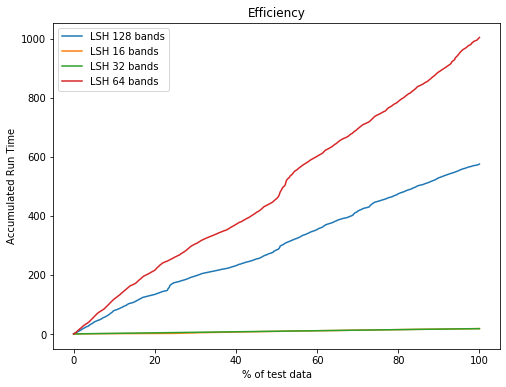

In [153]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(0,figsize=(8,6))

x = [x/len(LSH_time)*100 for x in range(len(LSH_time))]

# line_BFL, = plt.plot(x, BFL_time, label='BFL')
line_LSH, = plt.plot(x, LSH_time, label='LSH 128 bands')
line_LSH_16b, = plt.plot(x, LSH_time_16b, label='LSH 16 bands')
line_LSH_32b, = plt.plot(x, LSH_time_32b, label='LSH 32 bands')
line_LSH_64b, = plt.plot(x, LSH_time_64b, label='LSH 64 bands')

plt.title('Efficiency')
plt.xlabel('% of test data')
plt.ylabel('Accumulated Run Time')
# plt.ylim([0,2])
plt.legend(handles=[line_LSH,line_LSH_16b,line_LSH_32b,line_LSH_64b], loc=0)

plt.show()
plt.close()

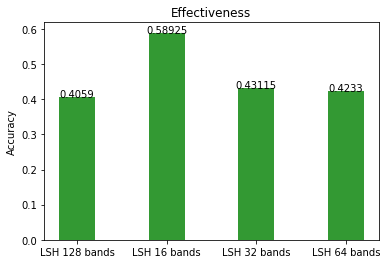

In [154]:
import matplotlib.pyplot as plt

effectiveness = [score_lsh,score_lsh_16b,score_lsh_32b,score_lsh_64b]

plt.bar(range(4), effectiveness, 0.4,color='g', alpha = 0.8,align='center')

plt.ylabel('Accuracy')
plt.title('Effectiveness')

plt.xticks(range(4),['LSH 128 bands','LSH 16 bands','LSH 32 bands','LSH 64 bands'])

for x,y in enumerate(effectiveness):
    plt.text(x,y,'%s' %y,ha='center')

plt.show()